## 策略逻辑：
60分钟看长短期MA趋势， 15分钟做均线择时。

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 10; slowPeriod = 55
    signalMaPeriod = 20
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod',
                 'signalMaPeriod'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        pass
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        pass
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 配置引擎回测

In [2]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180901 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期

    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2019-01-22 10:30:58.394764	开始回测
2019-01-22 10:30:58.394869	策略初始化
2019-01-22 10:31:00.396860	数据载入完成, 时间段:[20180824 04:00,20180901 12:00);数据量:12000
2019-01-22 10:31:00.397325	初始化预加载数据成功, 数据长度:12000
2019-01-22 10:31:00.397513	策略初始化完成
2019-01-22 10:31:00.397605	策略启动完成
2019-01-22 10:31:00.397739	回测时间范围:[20180901 12:00,20181123 12:00)
2019-01-22 10:31:00.397857	当前回放的时间段:[20180901 12:00,20181123 12:00)
2019-01-22 10:31:20.896751	数据载入完成, 时间段:[20180901 12:00,20181123 12:00);数据量:118890
2019-01-22 10:31:21.440676	数据载入完成, 时间段:[20180831 20:51,20180903 12:01);数据量:3790
2019-01-22 10:31:29.458759	数据载入完成, 时间段:[20180725 15:00,20180831 20:50);数据量:53630
2019-01-22 10:31:29.472939	WARNING: 该时间段:[20180903 12:01,20180903 13:00) 数据量为0!
2019-01-22 10:32:02.910776	回放结束ress: 100%    


In [3]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,rawData,status,symbol,tradeDatetime,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
0,多,,,0.0,,开仓,1,,7054.02,None,,,2018-09-01 13:00:00,1,20180901 13:00:00,1,1,BTCUSDT:binance,1
1,空,,,0.0,,平仓,2,,6991.02,None,,,2018-09-05 20:00:00,2,20180905 20:00:00,1,2,BTCUSDT:binance,2
2,空,,,0.0,,开仓,3,,6991.02,None,,,2018-09-05 20:00:00,3,20180905 20:00:00,1,3,BTCUSDT:binance,3
3,多,,,0.0,,平仓,4,,6467.26,None,,,2018-09-08 18:00:00,4,20180908 18:00:00,1,4,BTCUSDT:binance,4
4,多,,,0.0,,开仓,5,,6467.26,None,,,2018-09-08 18:00:00,5,20180908 18:00:00,1,5,BTCUSDT:binance,5
5,空,,,0.0,,平仓,6,,6404.41,None,,,2018-09-08 23:00:00,6,20180908 23:00:00,1,6,BTCUSDT:binance,6
6,空,,,0.0,,开仓,7,,6404.41,None,,,2018-09-08 23:00:00,7,20180908 23:00:00,1,7,BTCUSDT:binance,7
7,多,,,0.0,,平仓,8,,6375.57,None,,,2018-09-10 02:00:00,8,20180910 02:00:00,1,8,BTCUSDT:binance,8
8,多,,,0.0,,开仓,9,,6375.57,None,,,2018-09-10 02:00:00,9,20180910 02:00:00,1,9,BTCUSDT:binance,9
9,空,,,0.0,,平仓,10,,6308.57,None,,,2018-09-10 11:30:00,10,20180910 11:30:00,1,10,BTCUSDT:binance,10


## 查看绩效与优化

2019-01-22 10:32:03.191062	计算按日统计结果
2019-01-22 10:32:03.314033	------------------------------
2019-01-22 10:32:03.314210	首个交易日：	2018-09-01 00:00:00
2019-01-22 10:32:03.314272	最后交易日：	2018-11-23 00:00:00
2019-01-22 10:32:03.314582	总交易日：	84
2019-01-22 10:32:03.314646	盈利交易日	49
2019-01-22 10:32:03.314693	亏损交易日：	34
2019-01-22 10:32:03.314745	起始资金：	1000000
2019-01-22 10:32:03.314860	结束资金：	1,002,436.79
2019-01-22 10:32:03.314952	总收益率：	0.24%
2019-01-22 10:32:03.315034	年化收益：	0.7%
2019-01-22 10:32:03.315113	总盈亏：	2,436.79
2019-01-22 10:32:03.315197	最大回撤: 	-672.96
2019-01-22 10:32:03.315279	百分比最大回撤: -0.07%
2019-01-22 10:32:03.315370	总手续费：	263.63
2019-01-22 10:32:03.315443	总滑点：	0.17
2019-01-22 10:32:03.315522	总成交金额：	527,267.78
2019-01-22 10:32:03.315796	总成交笔数：	83
2019-01-22 10:32:03.316789	日均盈亏：	29.01
2019-01-22 10:32:03.316906	日均手续费：	3.14
2019-01-22 10:32:03.318966	日均滑点：	0.0
2019-01-22 10:32:03.319092	日均成交金额：	6,277.0
2019-01-22 10:32:03.319242	日均成交笔数：	0.99
2019-01-22 10:32:03.319336	日均收益率：	0.0%
201

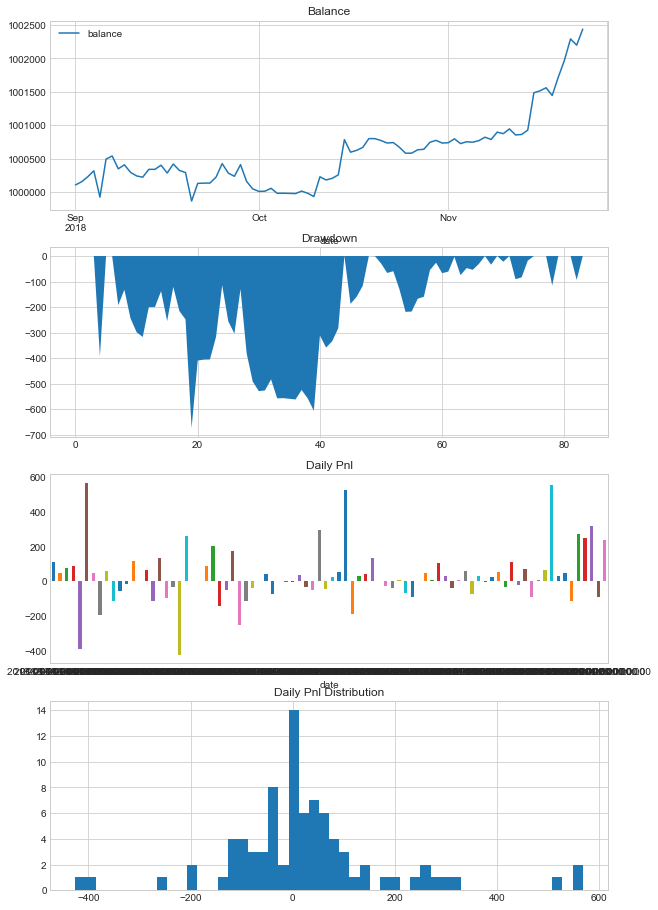

In [4]:
# 显示逐日回测结果
engine.showDailyResult()

2019-01-22 10:32:07.437509	计算回测结果
2019-01-22 10:32:07.447359	------------------------------
2019-01-22 10:32:07.447656	第一笔交易：	2018-09-05 20:00:00
2019-01-22 10:32:07.447730	最后一笔交易：	2018-11-23 11:58:00
2019-01-22 10:32:07.447796	总交易次数：	42
2019-01-22 10:32:07.448252	总盈亏：	2,434.63
2019-01-22 10:32:07.448409	最大回撤: 	-580.73
2019-01-22 10:32:07.448501	平均每笔盈利：	57.97
2019-01-22 10:32:07.448581	平均每笔滑点：	0.0
2019-01-22 10:32:07.448658	平均每笔佣金：	6.33
2019-01-22 10:32:07.448739	胜率		35.71%
2019-01-22 10:32:07.448994	盈利交易平均值	280.23
2019-01-22 10:32:07.449089	亏损交易平均值	-65.51
2019-01-22 10:32:07.449172	盈亏比：	4.28


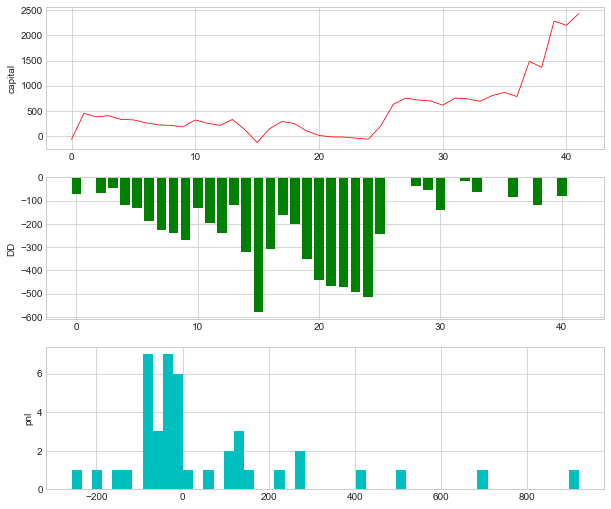

In [5]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [6]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)
print(pd.Series(result))

2019-01-22 10:32:09.079140	计算按日统计结果
startDate           2018-09-01 00:00:00
endDate             2018-11-23 00:00:00
totalDays                            84
profitDays                           49
lossDays                             34
endBalance                  1.00244e+06
maxDrawdown                    -672.962
maxDdPercent                 -0.0672597
totalNetPnl                     2436.79
dailyNetPnl                     29.0094
totalCommission                 263.634
dailyCommission                  3.1385
totalSlippage                     0.166
dailySlippage                0.00197619
totalTurnover                    527268
dailyTurnover                      6277
totalTradeCount                      83
dailyTradeCount                0.988095
totalReturn                    0.243679
annualizedReturn               0.696226
dailyReturn                  0.00290094
returnStd                     0.0160005
sharpeRatio                     2.80873
dtype: object


In [7]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod', 20, 40, 10)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('slowPeriod', 40, 80, 20)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2019-01-22 10:32:09.568360	------------------------------
2019-01-22 10:32:09.568737	setting: {'fastPeriod': 20, 'slowPeriod': 40, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2019-01-22 10:32:09.619163	开始回测
2019-01-22 10:32:09.620861	策略初始化
2019-01-22 10:32:11.377589	数据载入完成, 时间段:[20180824 04:00,20180901 12:00);数据量:12000
2019-01-22 10:32:11.377992	初始化预加载数据成功, 数据长度:12000
2019-01-22 10:32:11.378130	策略初始化完成
2019-01-22 10:32:11.378226	策略启动完成
2019-01-22 10:32:11.378342	回测时间范围:[20180901 12:00,20181123 12:00)
2019-01-22 10:32:11.378447	当前回放的时间段:[20180901 12:00,20181123 12:00)
2019-01-22 10:32:29.666743	数据载入完成, 时间段:[20180901 12:00,20181123 12:00);数据量:118890
2019-01-22 10:32:30.167953	数据载入完成, 时间段:[20180831 20:51,20180903 12:01);数据量:3790
2019-01-22 10:32:37.966625	数据载入完成, 时间段:[20180725 15:00,20180831 20:50);数据量:53630
2019-01-22 10:32:37.986731	WARNING: 该时间段:[20180903 12:01,20180903 13:00) 数据量为0!
2019-01-22 10:33:04.888522	回放结束ress: 100

2019-01-22 10:36:32.892528	回放结束ress: 100%    
2019-01-22 10:36:32.892649	计算按日统计结果
2019-01-22 10:36:32.971293	------------------------------
2019-01-22 10:36:32.971451	setting: {'fastPeriod': 40, 'slowPeriod': 80, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2019-01-22 10:36:32.999209	开始回测
2019-01-22 10:36:32.999714	策略初始化
2019-01-22 10:36:33.854634	数据载入完成, 时间段:[20180824 04:00,20180901 12:00);数据量:12000
2019-01-22 10:36:33.854989	初始化预加载数据成功, 数据长度:12000
2019-01-22 10:36:33.855122	策略初始化完成
2019-01-22 10:36:33.855171	策略启动完成
2019-01-22 10:36:33.855237	回测时间范围:[20180901 12:00,20181123 12:00)
2019-01-22 10:36:33.855295	当前回放的时间段:[20180901 12:00,20181123 12:00)
2019-01-22 10:36:42.387397	数据载入完成, 时间段:[20180901 12:00,20181123 12:00);数据量:118890
2019-01-22 10:36:42.653005	数据载入完成, 时间段:[20180831 20:51,20180903 12:01);数据量:3790
2019-01-22 10:36:46.498688	数据载入完成, 时间段:[20180725 15:00,20180831 20:50);数据量:53630
2019-01-22 10:36:46.506505	WARNING: 该时

### 打印最优结果排序的DataFrame

In [8]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                   0         1  \
0  [{'fastPeriod': 20, 'slowPeriod': 60, 'symbolL...  3.999466   
1  [{'fastPeriod': 20, 'slowPeriod': 80, 'symbolL...  3.940668   
2  [{'fastPeriod': 30, 'slowPeriod': 80, 'symbolL...  3.359490   
3  [{'fastPeriod': 30, 'slowPeriod': 60, 'symbolL...  3.203900   
4  [{'fastPeriod': 40, 'slowPeriod': 40, 'symbolL...  3.195254   
5  [{'fastPeriod': 40, 'slowPeriod': 60, 'symbolL...  3.098885   
6  [{'fastPeriod': 40, 'slowPeriod': 80, 'symbolL...  2.759817   
7  [{'fastPeriod': 20, 'slowPeriod': 40, 'symbolL...  2.756912   
8  [{'fastPeriod': 30, 'slowPeriod': 40, 'symbolL...  2.059806   

                                                   2  
0  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
1  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
2  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
3  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
4  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
5  {'star

In [9]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'fastPeriod': 20, 'slowPeriod': 60, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.99946618862
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：50
lossDays：33
endBalance：1003090.02179
maxDrawdown：-312.15649
maxDdPercent：-0.0311761769116
totalNetPnl：3090.02179
dailyNetPnl：36.7859736905
totalCommission：216.67421
dailyCommission：2.57945488095
totalSlippage：0.134
dailySlippage：0.00159523809524
totalTurnover：433348.42
dailyTurnover：5158.9097619
totalTradeCount：67
dailyTradeCount：0.797619047619
totalReturn：0.309002179
annualizedReturn：0.882863368571
dailyReturn：0.0036785973690476154
returnStd：0.014249047923709873
sharpeRatio：3.99946618862
------------------------------
参数：["{'fastPeriod': 20, 'slowPeriod': 80, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.9406684065
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：48
lossDays：35
endBalance：1003098.5428
maxDrawdown：-411.02698
maxDdPercent